In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the data
temp_data = pd.read_csv('/content/drive/MyDrive/7th sem Project/NEW PUMP2 TEMP NEW_temperature.csv')

# Drop rows with missing values
temp_data = temp_data.dropna()

# Extracting and labeling the data
pump1_temp_data = temp_data['Pump1 Temp'].values.reshape(-1, 1)
pump4_temp_data = temp_data['Pump2 Temp'].values.reshape(-1, 1)

# Labels: 0 for Pump1 (healthy), 1 for Pump4 (faulty)
pump1_temp_labels = np.zeros(len(pump1_temp_data))
pump4_temp_labels = np.ones(len(pump4_temp_data))

# Normalizing the data
scaler = MinMaxScaler(feature_range=(-1, 1))
pump1_temp_data_normalized = scaler.fit_transform(pump1_temp_data)
pump4_temp_data_normalized = scaler.fit_transform(pump4_temp_data)

# Function to create sequences
def create_sequences(data, labels, sequence_length=100):
    sequence_data = []
    sequence_labels = []
    for i in range(len(data) - sequence_length):
        sequence_data.append(data[i:i+sequence_length])
        sequence_labels.append(labels[i+sequence_length-1])
    return np.array(sequence_data), np.array(sequence_labels)

# Creating sequences for both Pump1 and Pump4
pump1_temp_sequences, pump1_temp_sequence_labels = create_sequences(pump1_temp_data_normalized, pump1_temp_labels)
pump4_temp_sequences, pump4_temp_sequence_labels = create_sequences(pump4_temp_data_normalized, pump4_temp_labels)

# Combining the sequences and labels
X_temp = np.vstack((pump1_temp_sequences, pump4_temp_sequences))
y_temp = np.hstack((pump1_temp_sequence_labels, pump4_temp_sequence_labels))

# Splitting the data into training and test sets
X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
input_shape = (100, 1)  # Adjusted for reduced sequence length
head_size = 128  # Reduced head size
num_heads = 2   # Reduced number of heads
ff_dim = 2      # Reduced feed-forward dimensions
num_transformer_blocks = 2  # Reduced transformer blocks for simplification
mlp_units = [64]  # Reduced MLP units for simplification
dropout = 0.1
mlp_dropout = 0.1

# Build the model
model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout)
# Increase batch size
batch_size = 256

# Use learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)  # Added gradient clipping
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Train the model with increased batch size
history = model.fit(X_temp_train, y_temp_train, epochs=5, batch_size=batch_size, validation_split=0.2, shuffle=False)  # Reduced epochs for faster training

Epoch 1/5
118/118 [==============================] - 178s 1s/step - loss: 0.1504 - accuracy: 0.9574 - val_loss: 0.0993 - val_accuracy: 0.9808
Epoch 2/5
118/118 [==============================] - 156s 1s/step - loss: 0.0910 - accuracy: 0.9845 - val_loss: 0.0872 - val_accuracy: 0.9850
Epoch 3/5
118/118 [==============================] - 161s 1s/step - loss: 0.0850 - accuracy: 0.9858 - val_loss: 0.0804 - val_accuracy: 0.9866
Epoch 4/5
118/118 [==============================] - 160s 1s/step - loss: 0.0786 - accuracy: 0.9869 - val_loss: 0.0736 - val_accuracy: 0.9874
Epoch 5/5
118/118 [==============================] - 161s 1s/step - loss: 0.0721 - accuracy: 0.9887 - val_loss: 0.0669 - val_accuracy: 0.9872


In [ ]:
from tensorflow.keras import layers
# Simplified Transformer block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

# Simplified model configuration
input_shape = (40, 1)  # Adjusted for reduced sequence length
head_size = 128  # Reduced head size
num_heads = 2   # Reduced number of heads
ff_dim = 2      # Reduced feed-forward dimensions
num_transformer_blocks = 2  # Reduced transformer blocks for simplification
mlp_units = [64]  # Reduced MLP units for simplification
dropout = 0.1
mlp_dropout = 0.1

# Build the model
model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout)


NameError: name 'tf' is not defined

In [ ]:
def build_transformer_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Predict on the test data
y_pred = model.predict(X_temp_test)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_temp_test, y_pred_binary)
precision = precision_score(y_temp_test, y_pred_binary)
recall = recall_score(y_temp_test, y_pred_binary)
f1 = f1_score(y_temp_test, y_pred_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

296/296 [==============================] - 18s 58ms/step
Accuracy: 0.9867
Precision: 0.9896
Recall: 0.9838
F1 Score: 0.9867


              precision    recall  f1-score   support

     Healthy       0.98      0.99      0.99      4699
      Faulty       0.99      0.98      0.99      4742

    accuracy                           0.99      9441
   macro avg       0.99      0.99      0.99      9441
weighted avg       0.99      0.99      0.99      9441



Text(0.5, 1.0, 'Accuracy')

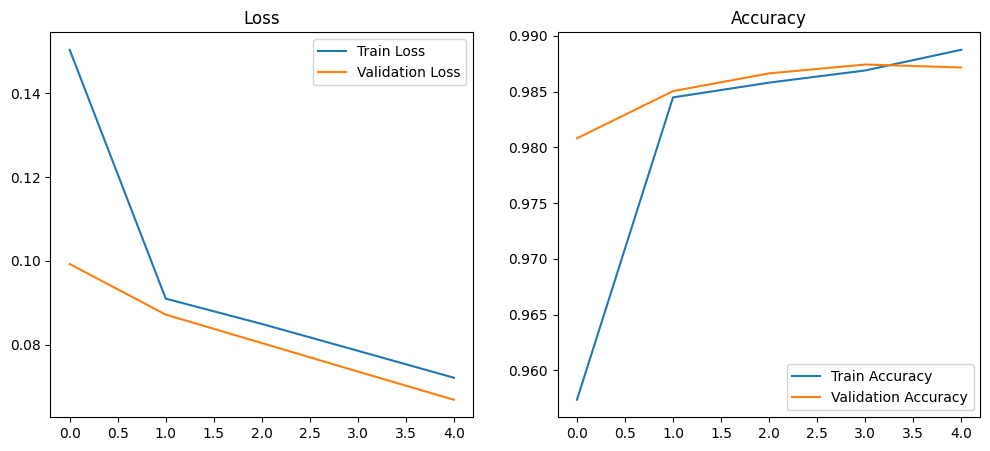

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# Printing classification report for precision, recall, f1-score metrics
print(classification_report(y_temp_test, y_pred_binary, target_names=['Healthy', 'Faulty']))

# Visualization - Plotting loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

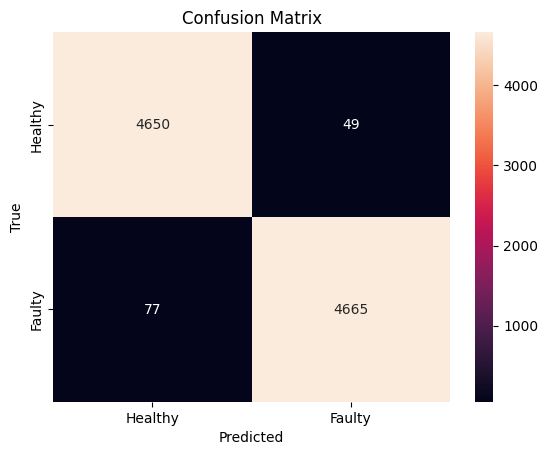

In [ ]:
cm = confusion_matrix(y_temp_test,y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Healthy', 'Faulty'], yticklabels=['Healthy', 'Faulty'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()